<a href="https://colab.research.google.com/github/ajgquional/LiL_Synthetic-Data-AI-Privacy/blob/main/Using_Synthetic_Data_for_Explainable_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Explain ML Model with Synthetic Data (Train-Real-Explain-Synthetic)

Install SHAP library to explain the output of a ML model. See https://shap-lrjball.readthedocs.io/en/latest/ for further details on SHAP.

In [1]:
# install required Python packages
!pip install -q shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 7.9 MB/s eta 0:00:00


### Load Data

In [2]:
import pandas as pd

# upload synthetic dataset
data_path = '.'
print("adapt `syn_file_path` to point to your generated synthetic data file")
syn_file_path = f'{data_path}/paris-synthetic.csv'
syn = pd.read_csv(syn_file_path)
print(f"read synthetic data with {syn.shape[0]:,} records and {syn.shape[1]:,} attributes")

# fetch training and holdout data
train = pd.read_csv(f'{data_path}/paris-training.csv')
print(f'read training data with {train.shape[0]:,} records and {train.shape[1]} attributes')
holdout = pd.read_csv(f'{data_path}/paris-holdout.csv')
print(f'read holdout data with {holdout.shape[0]:,} records and {holdout.shape[1]} attributes')


adapt `syn_file_path` to point to your generated synthetic data file
read synthetic data with 45,380 records and 17 attributes
read training data with 45,380 records and 17 attributes
read holdout data with 11,346 records and 17 attributes


### Train Model on Original Data

In [3]:
import lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

target_col = 'price'
target_val = 'above $100'

def prepare_xy(df):
    y = (df[target_col]==target_val).astype(int)
    X = df[[c for c in df if c != target_col]]
    # convert string columns to Categoricals
    for col in X.select_dtypes(['object', 'string']):
        X[col] = pd.Categorical(X[col])
    return X, y

def train_model(X, y):
    cat_cols = list(X.select_dtypes('category').columns)
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
    ds_trn = lgb.Dataset(X_trn, label=y_trn, categorical_feature=cat_cols, free_raw_data=False)
    ds_val = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_cols, free_raw_data=False)
    model = lgb.train(
        params={
            'metric': 'auc',
            'objective': 'binary'
        },
        train_set=ds_trn,
        valid_sets=[ds_val],
        callbacks=[early_stopping(5)],
    )
    return model

import warnings
warnings.filterwarnings('ignore')

In [4]:
# prepare original training data, and split into features `X` and target `y`
X_trn, y_trn = prepare_xy(train)
# train ML model on original training data with early stopping to prevent overfitting
model_trn = train_model(X_trn, y_trn)

[LightGBM] [Info] Number of positive: 20649, number of negative: 15655
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 36304, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.568780 -> initscore=0.276877
[LightGBM] [Info] Start training from score 0.276877
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[75]	valid_0's auc: 0.901274


### Calculate SHAP values for trained model w/ synthetic data

Important: For this step no access to the original (privacy-sensitive) training data is needed anymore. We only need access to the trained model for inference, as well as to representative synthetic data.

In [5]:
import shap
explainer = shap.TreeExplainer(model_trn)
X_syn, y_syn = prepare_xy(syn)
shap_values = explainer.shap_values(X_syn)
p_syn = model_trn.predict(X_syn)

### Shap Feature Importance

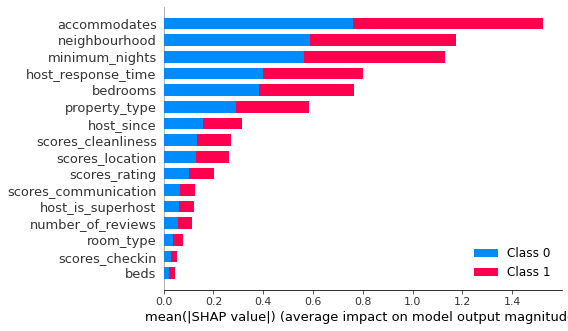

In [6]:
shap.initjs()
shap.summary_plot(shap_values, X_syn, plot_size=0.2)

### SHAP Dependency Plots

Let's study the value-dependent impact of each model feature. SHAP dependency plots are a great way to do so, as they not only show the average lift, but also the level of variance of that lift, at the same time.

In [7]:
import numpy as np

def plot_shap_dependency(col):
    col_idx = [i for i in range(X_syn.shape[1]) if X_syn.columns[i]==col][0]
    shp_vals = pd.Series(shap_values[1][:,col_idx], name='shap_value')
    col_vals = X_syn.iloc[:,col_idx].reset_index(drop=True)
    df = pd.concat([shp_vals, col_vals], axis=1)
    if col_vals.dtype.name != 'category':
        q01 = df[col].quantile(0.01)
        q99 = df[col].quantile(0.99)
        df = df.loc[(df[col] >= q01) & (df[col] <= q99), :]
    else:
        sorted_cats = list(df.groupby(col)['shap_value'].mean().sort_values().index)
        df[col] = df[col].cat.reorder_categories(sorted_cats, ordered=True)
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.ylim(-3.2, 3.2)
    plt.title(col)
    plt.xlabel('')
    if col_vals.dtype.name == 'category':
        plt.xticks(rotation = 90)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.tick_params(axis='both', which='minor', labelsize=6)
    p1 = sns.lineplot(x=df[col], y=df['shap_value'], color='black').axhline(0, color='gray', alpha=1, lw=0.5)
    p2 = sns.scatterplot(x=df[col], y=df['shap_value'], alpha=0.1)

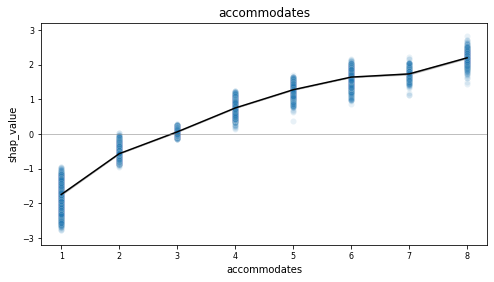

In [8]:
plot_shap_dependency('accommodates')

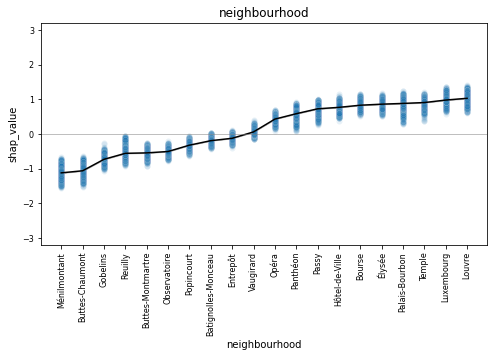

In [9]:
plot_shap_dependency('neighbourhood')

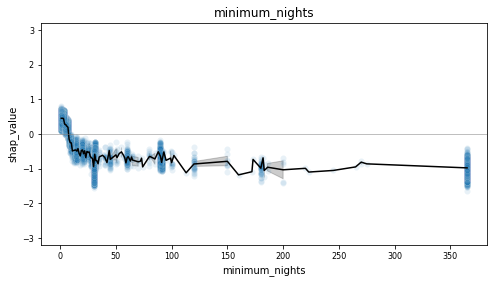

In [10]:
plot_shap_dependency('minimum_nights')

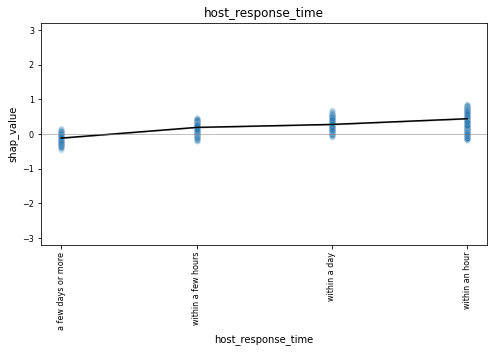

In [11]:
plot_shap_dependency('host_response_time')

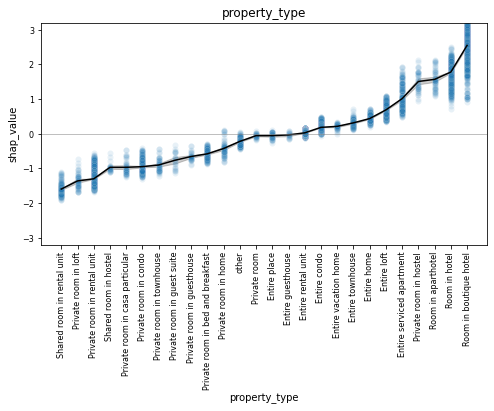

In [12]:
plot_shap_dependency('property_type')

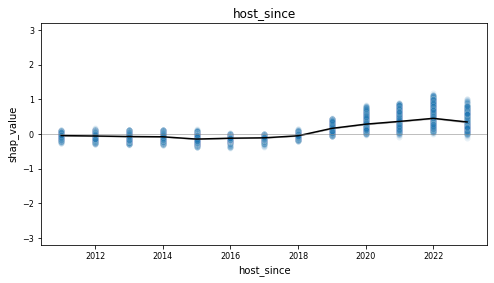

In [13]:
plot_shap_dependency('host_since')

### SHAP Values for Single (Synthetic) Samples

Let's study the factors behind the model scores by inspecting individual samples. Note, that this level of reasoning at an individual-level would not be possible with real data, if that consists of privacy-sensitive information. However, synthetic data allows to reason around samples at any scale.

In [14]:
def show_idx(i):
    shap.initjs()
    df = X_syn.iloc[i:i+1, :]
    df.insert(0, 'actual', y_syn.iloc[i])
    df.insert(1, 'score', p_syn[i])
    display(df)
    return shap.force_plot(explainer.expected_value[1], shap_values[1][i,:], X_syn.iloc[i,:], link="logit")

#### Show Random Sample

In [15]:
rnd_idx = X_syn.sample().index[0]
show_idx(rnd_idx)

,actual,score,host_since,host_response_time,host_is_superhost,neighbourhood,property_type,room_type,accommodates,bedrooms,beds,minimum_nights,number_of_reviews,scores_rating,scores_cleanliness,scores_checkin,scores_communication,scores_location
5502,1,0.850601,2016.0,within an hour,t,Popincourt,Entire rental unit,Entire home/apt,2,1.0,1.0,3,81,4.97,4.96,4.99,4.97,4.98


#### Show Sample with Lowest Score

In [16]:
idx = np.argsort(p_syn)[0]
show_idx(idx)

,actual,score,host_since,host_response_time,host_is_superhost,neighbourhood,property_type,room_type,accommodates,bedrooms,beds,minimum_nights,number_of_reviews,scores_rating,scores_cleanliness,scores_checkin,scores_communication,scores_location
30731,0,0.009567,2015.0,within an hour,f,Buttes-Montmartre,Shared room in rental unit,Shared room,1,1.0,1.0,1,208,4.51,4.74,4.92,4.92,4.25


#### Show Sample with Highest Score

In [17]:
idx = np.argsort(p_syn)[-1]
show_idx(idx)

,actual,score,host_since,host_response_time,host_is_superhost,neighbourhood,property_type,room_type,accommodates,bedrooms,beds,minimum_nights,number_of_reviews,scores_rating,scores_cleanliness,scores_checkin,scores_communication,scores_location
13267,1,0.996293,2022.0,within an hour,f,Luxembourg,Room in aparthotel,Private room,16,3.0,8.0,1,9,4.44,4.44,4.67,4.47,4.89


## Extras: Data Preparation

The following code snippet has been used to prepare the provided dataset

In [18]:
import pandas as pd
# download data
df = pd.read_csv('http://data.insideairbnb.com/france/ile-de-france/paris/2023-03-13/data/listings.csv.gz')
# use subset of columns
df = df[['price', 'host_since', 'host_response_time', 'host_is_superhost',
       'neighbourhood_cleansed',
       'property_type', 'room_type', 'accommodates', 'bedrooms',
       'beds', 'minimum_nights', 'number_of_reviews',
       'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location']]
# extract year of host_since
df['host_since'] = df['host_since'].str[:4]
# rename some columns for clarity
df.columns = [c.replace('review_scores', 'scores') for c in df]
df = df.rename(columns={'neighbourhood_cleansed': 'neighbourhood'})
# group long tail of property types into `other`
top_property_types = df.property_type.value_counts()[df.property_type.value_counts()>20].index
df.loc[~df.property_type.isin(top_property_types), 'property_type'] = 'other'
# convert price to numeric, and then to binary flag, depending on whether above or below $100
df.price = pd.to_numeric(df.price.str.replace(',', '').str[1:])
df.price = (df.price >= 100).replace({True: 'above $100', False: 'below $100'})
# split into training and holdout
df = df.sample(frac=1, random_state=123)
trn = df[:int(len(df)*0.8)]
hol = df[int(len(df)*0.8):]
trn.to_csv('paris-training.csv', index=False)
hol.to_csv('paris-holdout.csv', index=False)